In [176]:
import os, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import snowballstemmer
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin

In [177]:
train = pd.read_csv("train.csv") 
test = pd.read_csv('test.csv')

In [178]:
print(train.shape)
print(test.shape)

(10980, 12)
(3660, 11)


In [179]:
train.head(n=5)

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567900433542488064,negative,Southwest,NaN,ColeyGirouard,NaN,0,"@SouthwestAir I am scheduled for the morning, ...",NaN,2015-02-17 20:16:29 -0800,Washington D.C.,Atlantic Time (Canada)
1,569989168903819264,positive,Southwest,NaN,WalterFaddoul,NaN,0,@SouthwestAir seeing your workers time in and ...,NaN,2015-02-23 14:36:22 -0800,"Indianapolis, Indiana; USA",Central Time (US & Canada)
2,568089179520954368,positive,United,NaN,LocalKyle,NaN,0,@united Flew ORD to Miami and back and had gr...,NaN,2015-02-18 08:46:29 -0800,Illinois,Central Time (US & Canada)
3,568928195581513728,negative,Southwest,NaN,amccarthy19,NaN,0,@SouthwestAir @dultch97 that's horse radish 😤🐴,NaN,2015-02-20 16:20:26 -0800,NaN,Atlantic Time (Canada)
4,568594180014014464,negative,United,NaN,J_Okayy,NaN,0,@united so our flight into ORD was delayed bec...,NaN,2015-02-19 18:13:11 -0800,NaN,Eastern Time (US & Canada)


In [180]:
train.isnull().sum()

tweet_id                      0
airline_sentiment             0
airline                       0
airline_sentiment_gold    10949
name                          0
negativereason_gold       10956
retweet_count                 0
text                          0
tweet_coord               10204
tweet_created                 0
tweet_location             3550
user_timezone              3577
dtype: int64

In [181]:
train['airline_sentiment'].value_counts()

negative    6851
neutral     2327
positive    1802
Name: airline_sentiment, dtype: int64

In [182]:
new_train = train[['text', 'airline_sentiment']].copy()
new_test = test[['text']].copy()

In [183]:
print(new_train.shape)
print(new_test.shape)
print(new_train.head(n=5))
print(new_test.head(n=5))

(10980, 2)
(3660, 1)
                                                text airline_sentiment
0  @SouthwestAir I am scheduled for the morning, ...          negative
1  @SouthwestAir seeing your workers time in and ...          positive
2  @united Flew ORD to Miami and back and  had gr...          positive
3     @SouthwestAir @dultch97 that's horse radish 😤🐴          negative
4  @united so our flight into ORD was delayed bec...          negative
                                                text
0  @AmericanAir In car gng to DFW. Pulled over 1h...
1  @AmericanAir after all, the plane didn’t land ...
2  @SouthwestAir can't believe how many paying cu...
3  @USAirways I can legitimately say that I would...
4  @AmericanAir still no response from AA. great ...


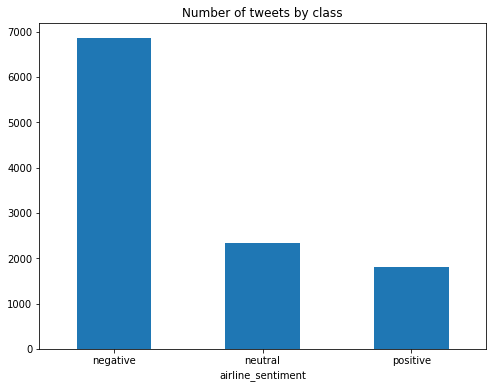

In [184]:
new_train.groupby(['airline_sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class');

In [185]:
new_train.sample(5)

,text,airline_sentiment
3980,@USAirways is there a phone number or email ad...,neutral
8153,@united rude rude,negative
1381,@united why do you hate your passengers?,negative
73,@USAirways right on. Up. Up &amp; away ✈️🌞,positive
2394,@AmericanAir No. Had to Cancelled Flight my tr...,negative


In [186]:
new_train.head(n=5)
new_test.sample(5)

,text
1986,@AmericanAir lost my wife's luggage and nobody...
2935,@USAirways website isnt working and I cant tal...
1615,@VirginAmerica Flight Booking Problems flight ...
1951,@USAirways Used 2 get emails 1) pre-purchase a...
10,@united your announcement for pre boarding onl...


In [187]:
type(new_train['text'])
new_train['text'].shape

(10980,)

In [188]:
import nltk
from nltk.tokenize import word_tokenize

In [189]:
#for i in new_train['text']:
 #   print(word_tokenize(i))

In [190]:
training_documents = []
for i in range(len(new_train['text'])):
    training_documents.append((word_tokenize(new_train['text'][i]), new_train['airline_sentiment'][i]))

In [191]:
training_documents[0:5]

[(['@',
   'SouthwestAir',
   'I',
   'am',
   'scheduled',
   'for',
   'the',
   'morning',
   ',',
   '2',
   'days',
   'after',
   'the',
   'fact',
   ',',
   'yes..not',
   'sure',
   'why',
   'my',
   'evening',
   'flight',
   'was',
   'the',
   'only',
   'one',
   'Cancelled',
   'Flightled'],
  'negative'),
 (['@',
   'SouthwestAir',
   'seeing',
   'your',
   'workers',
   'time',
   'in',
   'and',
   'time',
   'out',
   'going',
   'above',
   'and',
   'beyond',
   'is',
   'why',
   'I',
   'love',
   'flying',
   'with',
   'you',
   'guys',
   '.',
   'Thank',
   'you',
   '!'],
  'positive'),
 (['@',
   'united',
   'Flew',
   'ORD',
   'to',
   'Miami',
   'and',
   'back',
   'and',
   'had',
   'great',
   'crew',
   ',',
   'service',
   'on',
   'both',
   'legs',
   '.',
   'THANKS'],
  'positive'),
 (['@',
   'SouthwestAir',
   '@',
   'dultch97',
   'that',
   "'s",
   'horse',
   'radish',
   '😤🐴'],
  'negative'),
 (['@',
   'united',
   'so',
   'our',


In [192]:
testing_documents = []
print(word_tokenize(new_test['text'][2]))
len(new_test['text'])
for i in range(len(new_test['text'])):
#     testing_documents.append((word_tokenize(new_test['text'][i]), new_test['airline_sentiment'][i]))
    testing_documents.append(word_tokenize(new_test['text'][i]))

['@', 'SouthwestAir', 'ca', "n't", 'believe', 'how', 'many', 'paying', 'customers', 'you', 'left', 'high', 'and', 'dry', 'with', 'no', 'reason', 'for', 'flight', 'Cancelled', 'Flightlations', 'Monday', 'out', 'of', 'BDL', '!', 'Wow', '.']


In [193]:
testing_documents[0:5]

[['@',
  'AmericanAir',
  'In',
  'car',
  'gng',
  'to',
  'DFW',
  '.',
  'Pulled',
  'over',
  '1hr',
  'ago',
  '-',
  'very',
  'icy',
  'roads',
  '.',
  'On-hold',
  'with',
  'AA',
  'since',
  '1hr',
  '.',
  'Ca',
  "n't",
  'reach',
  'arpt',
  'for',
  'AA2450',
  '.',
  'Wat',
  '2',
  'do',
  '?'],
 ['@',
  'AmericanAir',
  'after',
  'all',
  ',',
  'the',
  'plane',
  'didn',
  '’',
  't',
  'land',
  'in',
  'identical',
  'or',
  'worse',
  ')',
  'conditions',
  'at',
  'GRK',
  'according',
  'to',
  'METARs',
  '.'],
 ['@',
  'SouthwestAir',
  'ca',
  "n't",
  'believe',
  'how',
  'many',
  'paying',
  'customers',
  'you',
  'left',
  'high',
  'and',
  'dry',
  'with',
  'no',
  'reason',
  'for',
  'flight',
  'Cancelled',
  'Flightlations',
  'Monday',
  'out',
  'of',
  'BDL',
  '!',
  'Wow',
  '.'],
 ['@',
  'USAirways',
  'I',
  'can',
  'legitimately',
  'say',
  'that',
  'I',
  'would',
  'have',
  'rather',
  'driven',
  'cross',
  'country',
  'than',


In [194]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [195]:
from nltk.corpus import wordnet
def get_simple_pos(tag):
    
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [196]:
from nltk import pos_tag
w = "better"
pos_tag([w])

[('better', 'RBR')]

In [197]:
from nltk.corpus import stopwords
import string
stops = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stops.update(punctuations)
stops, string.punctuation

({'!',
  '"',
  '#',
  '$',
  '%',
  '&',
  "'",
  '(',
  ')',
  '*',
  '+',
  ',',
  '-',
  '.',
  '/',
  ':',
  ';',
  '<',
  '=',
  '>',
  '?',
  '@',
  '[',
  '\\',
  ']',
  '^',
  '_',
  '`',
  'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',


In [198]:
def clean_review(words):
    output_words = []
    for w in words:
        if w.lower() not in stops:
            pos = pos_tag([w])
            clean_word = lemmatizer.lemmatize(w, pos = get_simple_pos(pos[0][1]))
            output_words.append(clean_word.lower())
    return output_words

In [199]:
training_documents = [(clean_review(document), category) for document, category in training_documents]
testing_documents = [(clean_review(document)) for document in testing_documents]

In [200]:
from sklearn.feature_extraction.text import CountVectorizer

In [201]:
categories = [category for document, category in training_documents]

In [202]:
text_documents = [" ".join(document) for document, category in training_documents]
tc = [" ".join(document) for document in testing_documents]

In [203]:
# from sklearn.model_selection import train_test_split

In [204]:
# x_train, x_test, y_train, y_test = train_test_split(text_documents, categories)

In [205]:
x_train = text_documents
y_train = categories
x_test = tc
print(len(x_train))
print(len(y_train))
print(len(x_test))

10980
10980
3660


In [206]:
#count_vec = CountVectorizer(max_features = 2000, min_df=7, max_df=0.8)
#x_train_features = count_vec.fit_transform(x_train)
#x_train_features.todense()

In [207]:
vectorizer = TfidfVectorizer(max_features=1000, max_df = 0.8)
x_train_features = vectorizer.fit_transform(text_documents)
x_test_features = vectorizer.transform(x_test)

In [208]:
#count_vec.get_feature_names()

In [209]:
#x_test_features = count_vec.transform(x_test)

In [210]:
#x_test_features.todense()

In [211]:
from sklearn.svm import SVC

In [212]:
svc = SVC(C = 1000)
svc.fit(x_train_features, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [213]:
pred = svc.predict(x_test_features)

In [214]:
svc.score(x_test_features, pred)

1.0

In [215]:
print(len(x_test))

3660


In [216]:
# c = np.savetxt('pred.csv', pred, delimiter =', ')
np.savetxt("predictions.csv", pred, fmt = '%s')